In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [3]:
df = pd.read_csv('../Data/product_return_prediction.csv')
print(f"Dataset shape: {df.shape}")
print(f"Return rate: {df['return_status'].mean():.2%}")

Dataset shape: (1500, 5)
Return rate: 27.07%


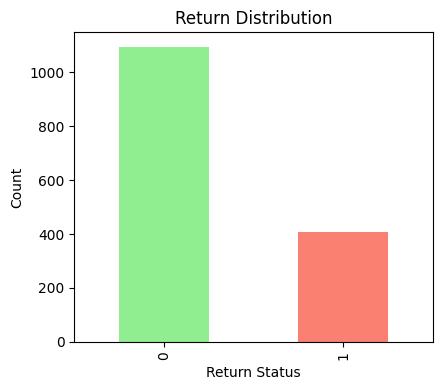

In [18]:
plt.figure(figsize=(12, 4))

# Return vs Not Returned count
plt.subplot(1, 3, 1)
df['return_status'].value_counts().plot(
    kind='bar',
    color=['lightgreen', 'salmon']
)
plt.title('Return Distribution')
plt.xlabel('Return Status')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

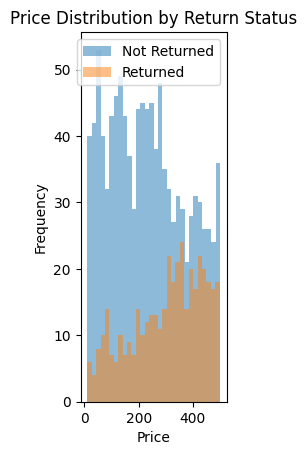

In [19]:
plt.subplot(1, 3, 2)

# Price distribution for returned vs not returned
for status in [0, 1]:
    price_data = df[df['return_status'] == status]['price']
    plt.hist(
        price_data,
        bins=30,
        alpha=0.5,
        label='Returned' if status == 1 else 'Not Returned'
    )

plt.title('Price Distribution by Return Status')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()


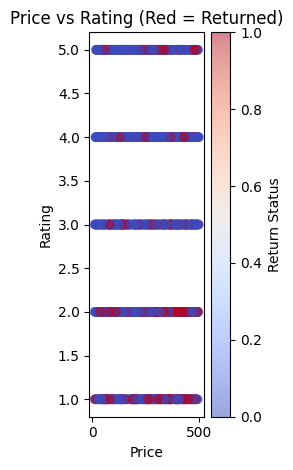

In [20]:
plt.subplot(1, 3, 3)

# Scatter plot to see relation between price, rating and returns
scatter = plt.scatter(
    df['price'],
    df['rating'],
    c=df['return_status'],
    alpha=0.5,
    cmap='coolwarm'
)

plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Price vs Rating (Red = Returned)')
plt.colorbar(scatter, label='Return Status')

plt.tight_layout()
plt.show()


In [24]:


# Feature engineering: combining price and rating impact
df['price_to_rating_ratio'] = df['price'] / (df['rating'] + 1)

# Flag for expensive products
df['high_price'] = (df['price'] > df['price'].median()).astype(int)

# Flag for poorly rated products
df['low_rating'] = (df['rating'] < 3).astype(int)


In [8]:
product_stats = df.groupby('product_id').agg({
    'return_status': 'mean',
    'price': 'mean'
}).rename(columns={'return_status': 'product_return_rate', 'price': 'avg_product_price'})

df = df.merge(product_stats, on='product_id', how='left')

In [26]:

features = ['price', 'rating', 'price_to_rating_ratio', 'high_price', 'low_rating',
            'product_return_rate', 'avg_product_price']
X = df[features]
y = df['return_status']




# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Train return rate: {y_train.mean():.2%}")
print(f"Test return rate: {y_test.mean():.2%}")

KeyError: "['product_return_rate', 'avg_product_price'] not in index"

In [10]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }


MODEL PERFORMANCE

Logistic Regression:
  accuracy: 0.8400
  precision: 0.6602
  recall: 0.8395
  f1: 0.7391
  auc: 0.9276

Random Forest:
  accuracy: 0.8133
  precision: 0.6812
  recall: 0.5802
  f1: 0.6267
  auc: 0.8900


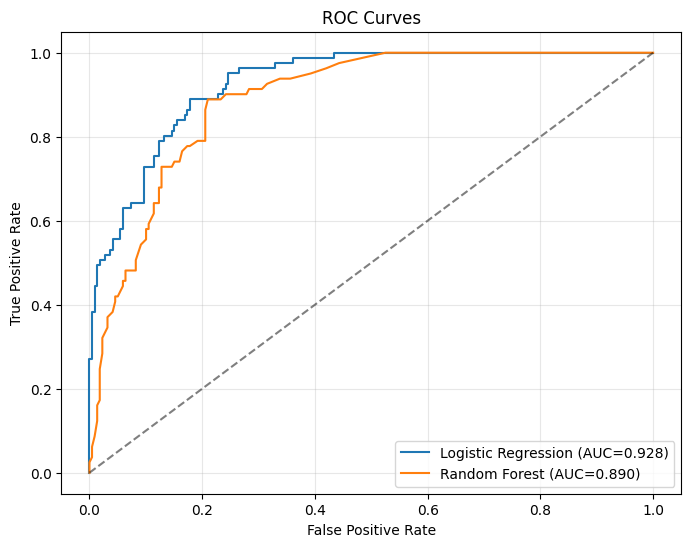

In [11]:
print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={results[name]["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


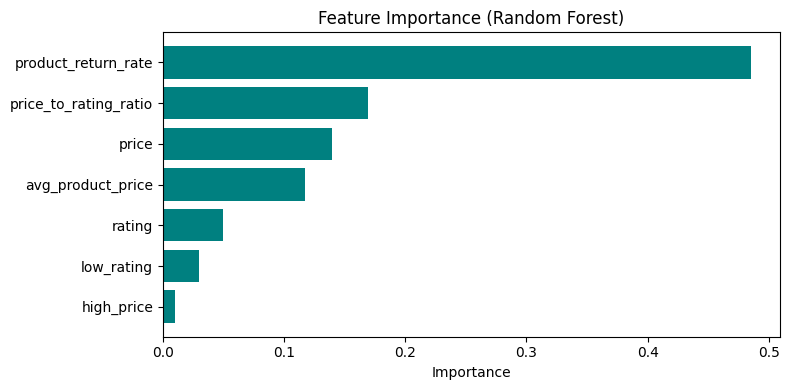

In [12]:
best_model = models['Random Forest']
importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(importance['feature'], importance['importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
final_features = X.columns.tolist()


In [16]:
final_features = X.columns.tolist()
print("FINAL FEATURES USED FOR TRAINING:")
print(final_features)


FINAL FEATURES USED FOR TRAINING:
['price', 'rating', 'price_to_rating_ratio', 'high_price', 'low_rating', 'product_return_rate', 'avg_product_price']


In [17]:
import os
import pickle

# go one level up from notebooks folder
MODEL_PATH = os.path.join("..", "model")

os.makedirs(MODEL_PATH, exist_ok=True)

with open(os.path.join(MODEL_PATH, "random_forest.pkl"), "wb") as f:
    pickle.dump(rf, f)

with open(os.path.join(MODEL_PATH, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(MODEL_PATH, "feature_order.pkl"), "wb") as f:
    pickle.dump(final_features, f)

print("✅ Model, scaler and feature order saved in main model folder")


NameError: name 'rf' is not defined

In [ ]:
# ================ 9. BUSINESS INSIGHTS ================
print("\n" + "="*50)
print("BUSINESS INSIGHTS")
print("="*50)

# Analyze high-risk products
high_risk = df[df['product_return_rate'] > 0.5]
if len(high_risk) > 0:
    print(f"\nHigh-risk products (return rate > 50%): {len(high_risk['product_id'].unique())}")

# Price segments
df['price_segment'] = pd.qcut(df['price'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
return_by_segment = df.groupby('price_segment')['return_status'].mean()
print("\nReturn rate by price segment:")
print(return_by_segment.round(3))

# Rating analysis
print("\nReturn rate by rating:")
print(df.groupby('rating')['return_status'].mean().round(3))